## Run the below import cell first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

## Run the cell below to get the data loaded and mostly ready

In [2]:
# condensing several of the above cells into this one
# One

conn = sqlite3.connect('stockPrediction.db')

query = "SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM price_history l INNER JOIN stock r ON r.stock_id = l.stock_id;"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

# columns = pd.MultiIndex.from_product([[i for i in symbols], ['open_price', 'high_price', 'low_price', 'close_price']], names=['symbol', 'type'])

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# Two

# remove stocks w/ less than 1000 data points
s = df.groupby(level=0).size()
# s = s.where(s > 1000).dropna()
s = s.where(s > 1550).dropna()  # playing around w/ different values here to get a model that can actually be trained
dfs = s.to_frame()
dfs = dfs.reset_index()
df = df.reset_index()
# dfs

# Three
df = pd.merge(df, dfs, how='inner', left_on='stock_symbol', right_on='stock_symbol', left_index=True)
df = df.drop_duplicates()
# this line below added in on 5/14 22:37:
df = df.drop(columns=[0])

# Four

# df = df.drop_duplicates(subset=['price_datetime'])
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])
df

open_price                                          \
stock_symbol              AACG   AAIC    AAME       AAU    ABEO   ABEV   
price_datetime                                                           
2021-02-11 09:30:00     6.0200  3.690  5.6100  0.963900  3.4550  2.820   
2021-02-11 09:45:00     6.2300  3.710  5.4500  0.918901  3.3796  2.855   
2021-02-11 10:00:00     6.0350  3.740  5.4999  0.936800  3.3070  2.830   
2021-02-11 10:15:00     5.9700  3.740  5.4100  0.939900  3.2886  2.835   
2021-02-11 10:30:00     5.9800  3.730  5.4466  0.947001  3.3300  2.830   
...                        ...    ...     ...       ...     ...    ...   
2021-05-12 15:15:00     2.7157  3.920  4.0100  0.522700  1.3950  3.235   
2021-05-12 15:30:00     2.7499  3.900  4.0100  0.515100  1.3950  3.225   
2021-05-12 15:45:00     2.7400  3.905  4.0200  0.519600  1.4000  3.225   
2021-05-12 15:59:18        NaN    NaN     NaN       NaN     NaN    NaN   
2021-05-12 15:59:59        NaN    NaN     NaN       NaN     NaN    NaN   

                                                    ... stock_splits       \
stock_symbol           ABIO   ABML    ABUS    ACER  ...          YPF YTRA   
price_datetime                                      ...                     
2021-02-11 09:30:00  5.2885  3.720  4.4100  4.1500  ...          NaN  NaN   
2021-02-11 09:45:00  5.4800  3.690  4.4213  4.1356  ...          NaN  NaN   
2021-02-11 10:00:00  5.4200  3.670  4.5393  4.3001  ...          NaN  NaN   
2021-02-11 10:15:00  5.3500  3.620  4.5900  4.4000  ...          NaN  NaN   
2021-02-11 10:30:00  5.3900  3.610  4.5200  4.5300  ...          NaN  NaN   
...                     ...    ...     ...     ...  ...          ...  ...   
2021-05-12 15:15:00  3.1900  1.520  2.7000     NaN  ...            0    0   
2021-05-12 15:30:00  3.1600  1.570  2.6950  2.6100  ...            0    0   
2021-05-12 15:45:00  3.1800  1.575  2.6991  2.6100  ...            0    0   
2021-05-12 15:59:18     NaN    NaN     NaN     NaN  ...          NaN  NaN   
2021-05-12 15:59:59     NaN    NaN     NaN     NaN  ...          NaN  NaN   

                                                             
stock_symbol         YVR ZIOP ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
price_datetime                                               
2021-02-11 09:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 09:45:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:15:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                  ...  ...  ...  ...  ...  ...  ...  ...  
2021-05-12 15:15:00    0    0    0    0    0    0    0    0  
2021-05-12 15:30:00    0    0    0    0    0    0    0    0  
2021-05-12 15:45:00    0    0    0    0    0    0    0    0  
2021-05-12 15:59:18  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-05-12 15:59:59  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1677 rows x 4515 columns]

In [21]:
df = df.reset_index()

In [14]:
df

price_datetime open_price                                   \
stock_symbol                            AACG   AAIC    AAME       AAU    ABEO   
0             2021-02-11 09:30:00     6.0200  3.690  5.6100  0.963900  3.4550   
1             2021-02-11 09:45:00     6.2300  3.710  5.4500  0.918901  3.3796   
2             2021-02-11 10:00:00     6.0350  3.740  5.4999  0.936800  3.3070   
3             2021-02-11 10:15:00     5.9700  3.740  5.4100  0.939900  3.2886   
4             2021-02-11 10:30:00     5.9800  3.730  5.4466  0.947001  3.3300   
...                           ...        ...    ...     ...       ...     ...   
1672          2021-05-12 15:15:00     2.7157  3.920  4.0100  0.522700  1.3950   
1673          2021-05-12 15:30:00     2.7499  3.900  4.0100  0.515100  1.3950   
1674          2021-05-12 15:45:00     2.7400  3.905  4.0200  0.519600  1.4000   
1675          2021-05-12 15:59:18        NaN    NaN     NaN       NaN     NaN   
1676          2021-05-12 15:59:59        NaN    NaN     NaN       NaN     NaN   

                                            ... stock_splits                 \
stock_symbol   ABEV    ABIO   ABML    ABUS  ...          YPF YTRA  YVR ZIOP   
0             2.820  5.2885  3.720  4.4100  ...          NaN  NaN  NaN  NaN   
1             2.855  5.4800  3.690  4.4213  ...          NaN  NaN  NaN  NaN   
2             2.830  5.4200  3.670  4.5393  ...          NaN  NaN  NaN  NaN   
3             2.835  5.3500  3.620  4.5900  ...          NaN  NaN  NaN  NaN   
4             2.830  5.3900  3.610  4.5200  ...          NaN  NaN  NaN  NaN   
...             ...     ...    ...     ...  ...          ...  ...  ...  ...   
1672          3.235  3.1900  1.520  2.7000  ...            0    0    0    0   
1673          3.225  3.1600  1.570  2.6950  ...            0    0    0    0   
1674          3.225  3.1800  1.575  2.6991  ...            0    0    0    0   
1675            NaN     NaN    NaN     NaN  ...          NaN  NaN  NaN  NaN   
1676            NaN     NaN    NaN     NaN  ...          NaN  NaN  NaN  NaN   

                                            
stock_symbol ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
0             NaN  NaN  NaN  NaN  NaN  NaN  
1             NaN  NaN  NaN  NaN  NaN  NaN  
2             NaN  NaN  NaN  NaN  NaN  NaN  
3             NaN  NaN  NaN  NaN  NaN  NaN  
4             NaN  NaN  NaN  NaN  NaN  NaN  
...           ...  ...  ...  ...  ...  ...  
1672            0    0    0    0    0    0  
1673            0    0    0    0    0    0  
1674            0    0    0    0    0    0  
1675          NaN  NaN  NaN  NaN  NaN  NaN  
1676          NaN  NaN  NaN  NaN  NaN  NaN  

[1677 rows x 4516 columns]

In [23]:
df['price_datetime'] = pd.to_datetime(df['price_datetime'])
df

price_datetime open_price                                   \
stock_symbol                           AACG   AAIC    AAME       AAU    ABEO   
0            2021-02-11 09:30:00     6.0200  3.690  5.6100  0.963900  3.4550   
1            2021-02-11 09:45:00     6.2300  3.710  5.4500  0.918901  3.3796   
2            2021-02-11 10:00:00     6.0350  3.740  5.4999  0.936800  3.3070   
3            2021-02-11 10:15:00     5.9700  3.740  5.4100  0.939900  3.2886   
4            2021-02-11 10:30:00     5.9800  3.730  5.4466  0.947001  3.3300   
...                          ...        ...    ...     ...       ...     ...   
1672         2021-05-12 15:15:00     2.7157  3.920  4.0100  0.522700  1.3950   
1673         2021-05-12 15:30:00     2.7499  3.900  4.0100  0.515100  1.3950   
1674         2021-05-12 15:45:00     2.7400  3.905  4.0200  0.519600  1.4000   
1675         2021-05-12 15:59:18        NaN    NaN     NaN       NaN     NaN   
1676         2021-05-12 15:59:59        NaN    NaN     NaN       NaN     NaN   

                                            ... stock_splits                 \
stock_symbol   ABEV    ABIO   ABML    ABUS  ...          YPF YTRA  YVR ZIOP   
0             2.820  5.2885  3.720  4.4100  ...          NaN  NaN  NaN  NaN   
1             2.855  5.4800  3.690  4.4213  ...          NaN  NaN  NaN  NaN   
2             2.830  5.4200  3.670  4.5393  ...          NaN  NaN  NaN  NaN   
3             2.835  5.3500  3.620  4.5900  ...          NaN  NaN  NaN  NaN   
4             2.830  5.3900  3.610  4.5200  ...          NaN  NaN  NaN  NaN   
...             ...     ...    ...     ...  ...          ...  ...  ...  ...   
1672          3.235  3.1900  1.520  2.7000  ...            0    0    0    0   
1673          3.225  3.1600  1.570  2.6950  ...            0    0    0    0   
1674          3.225  3.1800  1.575  2.6991  ...            0    0    0    0   
1675            NaN     NaN    NaN     NaN  ...          NaN  NaN  NaN  NaN   
1676            NaN     NaN    NaN     NaN  ...          NaN  NaN  NaN  NaN   

                                            
stock_symbol ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
0             NaN  NaN  NaN  NaN  NaN  NaN  
1             NaN  NaN  NaN  NaN  NaN  NaN  
2             NaN  NaN  NaN  NaN  NaN  NaN  
3             NaN  NaN  NaN  NaN  NaN  NaN  
4             NaN  NaN  NaN  NaN  NaN  NaN  
...           ...  ...  ...  ...  ...  ...  
1672            0    0    0    0    0    0  
1673            0    0    0    0    0    0  
1674            0    0    0    0    0    0  
1675          NaN  NaN  NaN  NaN  NaN  NaN  
1676          NaN  NaN  NaN  NaN  NaN  NaN  

[1677 rows x 4516 columns]

In [48]:
df[df['price_datetime'].dt.second == 0]

price_datetime open_price                                   \
stock_symbol                           AACG   AAIC    AAME       AAU    ABEO   
0            2021-02-11 09:30:00     6.0200  3.690  5.6100  0.963900  3.4550   
1            2021-02-11 09:45:00     6.2300  3.710  5.4500  0.918901  3.3796   
2            2021-02-11 10:00:00     6.0350  3.740  5.4999  0.936800  3.3070   
3            2021-02-11 10:15:00     5.9700  3.740  5.4100  0.939900  3.2886   
4            2021-02-11 10:30:00     5.9800  3.730  5.4466  0.947001  3.3300   
...                          ...        ...    ...     ...       ...     ...   
1670         2021-05-12 14:45:00     2.7400  3.930  3.9900  0.523100  1.4300   
1671         2021-05-12 15:00:00     2.7165  3.950  4.0150  0.522000  1.4307   
1672         2021-05-12 15:15:00     2.7157  3.920  4.0100  0.522700  1.3950   
1673         2021-05-12 15:30:00     2.7499  3.900  4.0100  0.515100  1.3950   
1674         2021-05-12 15:45:00     2.7400  3.905  4.0200  0.519600  1.4000   

                                            ... stock_splits                 \
stock_symbol   ABEV    ABIO   ABML    ABUS  ...          YPF YTRA  YVR ZIOP   
0             2.820  5.2885  3.720  4.4100  ...          NaN  NaN  NaN  NaN   
1             2.855  5.4800  3.690  4.4213  ...          NaN  NaN  NaN  NaN   
2             2.830  5.4200  3.670  4.5393  ...          NaN  NaN  NaN  NaN   
3             2.835  5.3500  3.620  4.5900  ...          NaN  NaN  NaN  NaN   
4             2.830  5.3900  3.610  4.5200  ...          NaN  NaN  NaN  NaN   
...             ...     ...    ...     ...  ...          ...  ...  ...  ...   
1670          3.265  3.2300  1.530  2.7388  ...            0    0    0    0   
1671          3.275  3.1920  1.520  2.7200  ...            0    0    0    0   
1672          3.235  3.1900  1.520  2.7000  ...            0    0    0    0   
1673          3.225  3.1600  1.570  2.6950  ...            0    0    0    0   
1674          3.225  3.1800  1.575  2.6991  ...            0    0    0    0   

                                            
stock_symbol ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
0             NaN  NaN  NaN  NaN  NaN  NaN  
1             NaN  NaN  NaN  NaN  NaN  NaN  
2             NaN  NaN  NaN  NaN  NaN  NaN  
3             NaN  NaN  NaN  NaN  NaN  NaN  
4             NaN  NaN  NaN  NaN  NaN  NaN  
...           ...  ...  ...  ...  ...  ...  
1670            0    0    0    0    0    0  
1671            0    0    0    0    0    0  
1672            0    0    0    0    0    0  
1673            0    0    0    0    0    0  
1674            0    0    0    0    0    0  

[1638 rows x 4516 columns]

In [51]:
df[(df['price_datetime'].dt.minute == 0) | (df['price_datetime'].dt.minute == 15) | (df['price_datetime'].dt.minute == 30) | (df['price_datetime'].dt.minute == 45)]

price_datetime open_price                                   \
stock_symbol                           AACG   AAIC    AAME       AAU    ABEO   
0            2021-02-11 09:30:00     6.0200  3.690  5.6100  0.963900  3.4550   
1            2021-02-11 09:45:00     6.2300  3.710  5.4500  0.918901  3.3796   
2            2021-02-11 10:00:00     6.0350  3.740  5.4999  0.936800  3.3070   
3            2021-02-11 10:15:00     5.9700  3.740  5.4100  0.939900  3.2886   
4            2021-02-11 10:30:00     5.9800  3.730  5.4466  0.947001  3.3300   
...                          ...        ...    ...     ...       ...     ...   
1670         2021-05-12 14:45:00     2.7400  3.930  3.9900  0.523100  1.4300   
1671         2021-05-12 15:00:00     2.7165  3.950  4.0150  0.522000  1.4307   
1672         2021-05-12 15:15:00     2.7157  3.920  4.0100  0.522700  1.3950   
1673         2021-05-12 15:30:00     2.7499  3.900  4.0100  0.515100  1.3950   
1674         2021-05-12 15:45:00     2.7400  3.905  4.0200  0.519600  1.4000   

                                            ... stock_splits                 \
stock_symbol   ABEV    ABIO   ABML    ABUS  ...          YPF YTRA  YVR ZIOP   
0             2.820  5.2885  3.720  4.4100  ...          NaN  NaN  NaN  NaN   
1             2.855  5.4800  3.690  4.4213  ...          NaN  NaN  NaN  NaN   
2             2.830  5.4200  3.670  4.5393  ...          NaN  NaN  NaN  NaN   
3             2.835  5.3500  3.620  4.5900  ...          NaN  NaN  NaN  NaN   
4             2.830  5.3900  3.610  4.5200  ...          NaN  NaN  NaN  NaN   
...             ...     ...    ...     ...  ...          ...  ...  ...  ...   
1670          3.265  3.2300  1.530  2.7388  ...            0    0    0    0   
1671          3.275  3.1920  1.520  2.7200  ...            0    0    0    0   
1672          3.235  3.1900  1.520  2.7000  ...            0    0    0    0   
1673          3.225  3.1600  1.570  2.6950  ...            0    0    0    0   
1674          3.225  3.1800  1.575  2.6991  ...            0    0    0    0   

                                            
stock_symbol ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
0             NaN  NaN  NaN  NaN  NaN  NaN  
1             NaN  NaN  NaN  NaN  NaN  NaN  
2             NaN  NaN  NaN  NaN  NaN  NaN  
3             NaN  NaN  NaN  NaN  NaN  NaN  
4             NaN  NaN  NaN  NaN  NaN  NaN  
...           ...  ...  ...  ...  ...  ...  
1670            0    0    0    0    0    0  
1671            0    0    0    0    0    0  
1672            0    0    0    0    0    0  
1673            0    0    0    0    0    0  
1674            0    0    0    0    0    0  

[1638 rows x 4516 columns]

In [52]:
df[(df['price_datetime'].dt.second == 0) & ((df['price_datetime'].dt.minute == 0) | (df['price_datetime'].dt.minute == 15) | (df['price_datetime'].dt.minute == 30) | (df['price_datetime'].dt.minute == 45))]

price_datetime open_price                                   \
stock_symbol                           AACG   AAIC    AAME       AAU    ABEO   
0            2021-02-11 09:30:00     6.0200  3.690  5.6100  0.963900  3.4550   
1            2021-02-11 09:45:00     6.2300  3.710  5.4500  0.918901  3.3796   
2            2021-02-11 10:00:00     6.0350  3.740  5.4999  0.936800  3.3070   
3            2021-02-11 10:15:00     5.9700  3.740  5.4100  0.939900  3.2886   
4            2021-02-11 10:30:00     5.9800  3.730  5.4466  0.947001  3.3300   
...                          ...        ...    ...     ...       ...     ...   
1670         2021-05-12 14:45:00     2.7400  3.930  3.9900  0.523100  1.4300   
1671         2021-05-12 15:00:00     2.7165  3.950  4.0150  0.522000  1.4307   
1672         2021-05-12 15:15:00     2.7157  3.920  4.0100  0.522700  1.3950   
1673         2021-05-12 15:30:00     2.7499  3.900  4.0100  0.515100  1.3950   
1674         2021-05-12 15:45:00     2.7400  3.905  4.0200  0.519600  1.4000   

                                            ... stock_splits                 \
stock_symbol   ABEV    ABIO   ABML    ABUS  ...          YPF YTRA  YVR ZIOP   
0             2.820  5.2885  3.720  4.4100  ...          NaN  NaN  NaN  NaN   
1             2.855  5.4800  3.690  4.4213  ...          NaN  NaN  NaN  NaN   
2             2.830  5.4200  3.670  4.5393  ...          NaN  NaN  NaN  NaN   
3             2.835  5.3500  3.620  4.5900  ...          NaN  NaN  NaN  NaN   
4             2.830  5.3900  3.610  4.5200  ...          NaN  NaN  NaN  NaN   
...             ...     ...    ...     ...  ...          ...  ...  ...  ...   
1670          3.265  3.2300  1.530  2.7388  ...            0    0    0    0   
1671          3.275  3.1920  1.520  2.7200  ...            0    0    0    0   
1672          3.235  3.1900  1.520  2.7000  ...            0    0    0    0   
1673          3.225  3.1600  1.570  2.6950  ...            0    0    0    0   
1674          3.225  3.1800  1.575  2.6991  ...            0    0    0    0   

                                            
stock_symbol ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
0             NaN  NaN  NaN  NaN  NaN  NaN  
1             NaN  NaN  NaN  NaN  NaN  NaN  
2             NaN  NaN  NaN  NaN  NaN  NaN  
3             NaN  NaN  NaN  NaN  NaN  NaN  
4             NaN  NaN  NaN  NaN  NaN  NaN  
...           ...  ...  ...  ...  ...  ...  
1670            0    0    0    0    0    0  
1671            0    0    0    0    0    0  
1672            0    0    0    0    0    0  
1673            0    0    0    0    0    0  
1674            0    0    0    0    0    0  

[1638 rows x 4516 columns]

In [3]:
# This cell removes weird datetime values
df = df.reset_index()
df['price_datetime'] = pd.to_datetime(df['price_datetime'])
df = df[(df['price_datetime'].dt.second == 0) & ((df['price_datetime'].dt.minute == 0) | (df['price_datetime'].dt.minute == 15) | (df['price_datetime'].dt.minute == 30) | (df['price_datetime'].dt.minute == 45))]
df = df.set_index('price_datetime')

In [5]:
# attempting once again to impute
columns = df.close_price.columns
# df = df.reset_index()
imputer = KNNImputer(n_neighbors=2, weights='distance')
imputed_data = imputer.fit_transform(df[['close_price']])
clean_data = pd.DataFrame(imputed_data, columns=columns)
# clean_data['price_datetime'] = df['price_datetime']
# df = pd.merge(df, clean_data, on='price_datetime')
clean_data

stock_symbol,AACG,AAIC,AAME,AAU,ABEO,ABEV,ABIO,ABML,ABUS,ACER,...,YPF,YTRA,YVR,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE
0,6.2300,3.7270,5.40,0.920000,3.3700,2.8600,5.4354,3.6865,4.4300,4.160000,...,4.758828,2.719063,2.230,4.702689,6.326563,0.849411,2.429055,1.669108,6.900830,5.791376
1,6.1000,3.7400,5.47,0.936200,3.3043,2.8350,5.4300,3.6600,4.5400,4.360000,...,4.758858,2.718976,2.230,4.702711,6.324401,0.849417,2.429166,1.669021,6.900284,5.791554
2,5.9783,3.7400,5.42,0.932201,3.2800,2.8400,5.3500,3.6100,4.6000,4.400000,...,4.758850,2.719001,2.230,4.702705,6.325023,0.849415,2.429134,1.669046,6.900441,5.791503
3,5.9971,3.7390,5.45,0.948600,3.3281,2.8311,5.3700,3.6200,4.5292,4.525000,...,4.758861,2.718968,2.230,4.702713,6.324205,0.849417,2.429176,1.669013,6.900234,5.791570
4,5.9125,3.7250,5.41,0.999800,3.3106,2.8300,5.4111,3.6145,4.5150,4.458200,...,4.758872,2.718936,2.230,4.702721,6.323410,0.849419,2.429217,1.668981,6.900033,5.791636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,2.7400,3.9500,4.00,0.523200,1.4400,3.2710,3.2100,1.5250,2.7200,2.650000,...,4.130000,1.828900,1.925,3.120000,4.625000,0.600000,0.783400,0.744951,3.470000,4.300000
1634,2.7100,3.9250,4.00,0.522800,1.3900,3.2350,3.2098,1.5200,2.7100,2.638000,...,4.115000,1.810000,1.930,3.110000,4.590000,0.595050,0.780300,0.746700,3.450000,4.260000
1635,2.7000,3.9050,4.01,0.520199,1.4000,3.2250,3.1600,1.5700,2.6900,2.615482,...,4.130000,1.800000,1.900,3.090000,4.600000,0.599000,0.775799,0.746300,3.460000,4.260000
1636,2.7200,3.9099,4.02,0.519500,1.4050,3.2250,3.1650,1.5700,2.6950,2.620000,...,4.125000,1.793200,1.910,3.085000,4.600000,0.610000,0.771300,0.744800,3.430000,4.250000


In [5]:
# This cell serves as an alternative to the above, avoiding the imputing entirely.
columns = df.close_price.columns
# clean_data = pd.DataFrame(df[['close_price']], columns=columns)
clean_data = df['close_price']
clean_data

stock_symbol,AACG,AAIC,AAME,AAU,ABEO,ABEV,ABIO,ABML,ABUS,ACER,...,YPF,YTRA,YVR,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE
0,6.2300,3.7270,5.40,0.920000,3.3700,2.8600,5.4354,3.6865,4.4300,4.1600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.1000,3.7400,5.47,0.936200,3.3043,2.8350,5.4300,3.6600,4.5400,4.3600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.9783,3.7400,5.42,0.932201,3.2800,2.8400,5.3500,3.6100,4.6000,4.4000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.9971,3.7390,5.45,0.948600,3.3281,2.8311,5.3700,3.6200,4.5292,4.5250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.9125,3.7250,5.41,0.999800,3.3106,2.8300,5.4111,3.6145,4.5150,4.4582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,2.7400,3.9500,4.00,0.523200,1.4400,3.2710,3.2100,1.5250,2.7200,2.6500,...,4.130,1.8289,1.925,3.120,4.625,0.60000,0.783400,0.744951,3.47,4.30
1671,2.7100,3.9250,4.00,0.522800,1.3900,3.2350,3.2098,1.5200,2.7100,2.6380,...,4.115,1.8100,1.930,3.110,4.590,0.59505,0.780300,0.746700,3.45,4.26
1672,2.7000,3.9050,4.01,0.520199,1.4000,3.2250,3.1600,1.5700,2.6900,NaN,...,4.130,1.8000,1.900,3.090,4.600,0.59900,0.775799,0.746300,3.46,4.26
1673,2.7200,3.9099,4.02,0.519500,1.4050,3.2250,3.1650,1.5700,2.6950,2.6200,...,4.125,1.7932,1.910,3.085,4.600,0.61000,0.771300,0.744800,3.43,4.25


In [6]:
# move the dataframes around as necessary and once again set the index to price_datetime
df['close_price'] = clean_data
df = df.set_index('price_datetime')

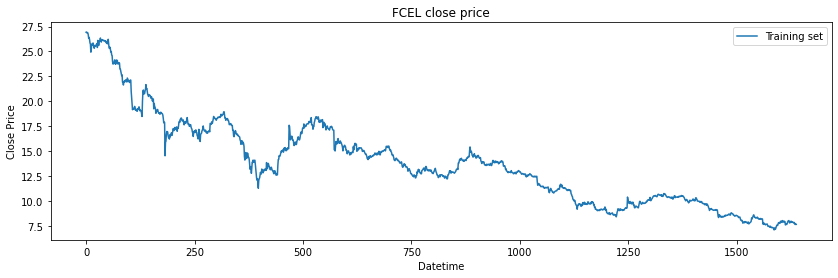

In [28]:
# testing the sets w/ matplotlib
plt.figure(figsize=(14,4))
plt.plot(df['close_price']['FCEL'])
# plt.plot(test_data['FCEL'])
plt.ylabel('Close Price')
plt.xlabel('Datetime')
plt.legend(["Training set", "Test set"])
plt.title("FCEL close price")
plt.show()

*The above is what is weird. The data I have is clearly fine, but when splitting it up for training/testing, it gets messed up. Going to work on getting my training/test split directly from the original dataframe instead of the way it is currently working*

## Test-train split below
Uses close prices only. Will try a future version that uses all available data.

In [6]:
# first cell for test-train split
data = df['close_price']
# data = data.reset_index()

# I am doing this differently. I am using 80% as training data, 20% as test
data_size = len(data)
training_data = data.iloc[:(int(data_size * .8))]
test_data = data.iloc[(int(data_size * .8)):]

In [23]:
# a lot of my nan's are occuring in the above cell for some reason? going to try imputing that data
# try running this one instead of the above cell
data = df['close_price']
# data = data.reset_index()
columns = df.close_price.columns
imputer = KNNImputer(n_neighbors=10, weights='distance')
imputed_data = imputer.fit_transform(df[['close_price']])
clean_data = pd.DataFrame(imputed_data, columns=columns)
data = clean_data
df = df.reset_index()
data['price_datetime'] = df['price_datetime']

# I am doing this differently. I am using 80% as training data, 20% as test
data_size = len(data)
training_data = data.iloc[:(int(data_size * .8))]
test_data = data.iloc[(int(data_size * .8)):]

In [19]:
data

stock_symbol,AACG,AAIC,AAME,AAU,ABEO,ABEV,ABIO,ABML,ABUS,ACER,...,YTRA,YVR,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE,price_datetime
0,6.2300,3.7270,5.40,0.920000,3.3700,2.8600,5.4354,3.6865,4.4300,4.160000,...,2.719063,2.230,4.702689,6.326563,0.849411,2.429055,1.669108,6.900830,5.791376,2021-02-11 09:30:00
1,6.1000,3.7400,5.47,0.936200,3.3043,2.8350,5.4300,3.6600,4.5400,4.360000,...,2.718976,2.230,4.702711,6.324401,0.849417,2.429166,1.669021,6.900284,5.791554,2021-02-11 09:45:00
2,5.9783,3.7400,5.42,0.932201,3.2800,2.8400,5.3500,3.6100,4.6000,4.400000,...,2.719001,2.230,4.702705,6.325023,0.849415,2.429134,1.669046,6.900441,5.791503,2021-02-11 10:00:00
3,5.9971,3.7390,5.45,0.948600,3.3281,2.8311,5.3700,3.6200,4.5292,4.525000,...,2.718968,2.230,4.702713,6.324205,0.849417,2.429176,1.669013,6.900234,5.791570,2021-02-11 10:15:00
4,5.9125,3.7250,5.41,0.999800,3.3106,2.8300,5.4111,3.6145,4.5150,4.458200,...,2.718936,2.230,4.702721,6.323410,0.849419,2.429217,1.668981,6.900033,5.791636,2021-02-11 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,2.7400,3.9500,4.00,0.523200,1.4400,3.2710,3.2100,1.5250,2.7200,2.650000,...,1.828900,1.925,3.120000,4.625000,0.600000,0.783400,0.744951,3.470000,4.300000,2021-05-12 14:45:00
1634,2.7100,3.9250,4.00,0.522800,1.3900,3.2350,3.2098,1.5200,2.7100,2.638000,...,1.810000,1.930,3.110000,4.590000,0.595050,0.780300,0.746700,3.450000,4.260000,2021-05-12 15:00:00
1635,2.7000,3.9050,4.01,0.520199,1.4000,3.2250,3.1600,1.5700,2.6900,2.615482,...,1.800000,1.900,3.090000,4.600000,0.599000,0.775799,0.746300,3.460000,4.260000,2021-05-12 15:15:00
1636,2.7200,3.9099,4.02,0.519500,1.4050,3.2250,3.1650,1.5700,2.6950,2.620000,...,1.793200,1.910,3.085000,4.600000,0.610000,0.771300,0.744800,3.430000,4.250000,2021-05-12 15:30:00


In [24]:
# second cell for test-train split
# adding the price_datetime index back
training_data = training_data.set_index('price_datetime')
test_data = test_data.set_index('price_datetime')

In [21]:
training_data.isna().sum()

stock_symbol
AACG    0
AAIC    0
AAME    0
AAU     0
ABEO    0
       ..
ZNOG    0
ZOM     0
ZSAN    0
ZVO     0
ZYNE    0
Length: 645, dtype: int64

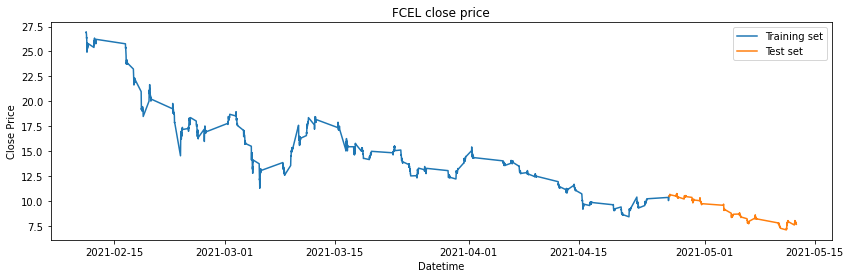

In [25]:
# testing the sets w/ matplotlib
plt.figure(figsize=(14,4))
plt.plot(training_data['FCEL'])
plt.plot(test_data['FCEL'])
plt.ylabel('Close Price')
plt.xlabel('Datetime')
plt.legend(["Training set", "Test set"])
plt.title("FCEL close price")
plt.show()

## Data Normalization
This method uses the MinMaxScaler, but a log return can sometimes be more useful. 

In [10]:
# drop security you'd like to predict w/ these lines
# first, it creates a new dataframe w/ only the security you'd like to predict
training_data_predicted = training_data['FCEL']
training_data_predicted = training_data_predicted.to_frame()
training_data_predicted

,FCEL
price_datetime,
2021-02-11 09:30:00,26.930000
2021-02-11 09:45:00,26.889999
2021-02-11 10:00:00,26.930000
2021-02-11 10:15:00,26.860001
2021-02-11 10:30:00,26.870001
...,...
2021-04-26 10:45:00,10.250000
2021-04-26 11:00:00,10.345000
2021-04-26 11:15:00,10.418700


In [ ]:
training_data.shape, training_data_predicted.shape

In [11]:
# I have altered this so it works better w/ my data.
minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

training_data = training_data.drop(columns='FCEL')

# no idea if the line below will work the way I need it to or not
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append('FCEL')

train_scaled = pd.DataFrame(train_scaled, columns=columns)
train_scaled

,AACG,AAIC,AAME,AAU,ABEO,ABEV,ABIO,ABML,ABUS,ACER,...,YTRA,YVR,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE,FCEL
0,0.966866,0.102667,0.669698,0.851893,0.922018,0.817769,0.997900,0.898661,0.892857,0.720034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,0.930851,0.120000,0.691503,0.881960,0.891881,0.772348,0.995434,0.889813,0.958333,0.810360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997842
2,0.897135,0.120000,0.675928,0.874538,0.880734,0.781432,0.958904,0.873118,0.994047,0.828426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
3,0.902344,0.118667,0.685273,0.904974,0.902798,0.765262,0.968036,0.876457,0.951905,0.884879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996224
4,0.878906,0.100000,0.672813,1.000000,0.894771,0.763263,0.986804,0.874620,0.943452,0.854710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0.063719,0.653333,0.274109,0.209169,0.153670,0.917696,0.146119,0.250392,0.250000,NaN,...,0.113636,0.265368,0.154959,0.251599,0.223881,0.113054,0.174917,0.070227,0.311870,0.100324
1306,0.060949,0.680000,0.277224,0.211117,0.155963,0.902253,0.154566,0.238706,0.261905,0.196143,...,0.125000,0.253007,0.154959,0.256429,0.223881,0.122093,0.178918,0.098317,0.304122,0.105448
1307,0.066489,0.680000,0.292487,0.207684,0.155963,0.895349,0.150685,0.243714,0.258929,0.187110,...,0.142045,0.254861,0.154959,0.248401,0.191898,0.123080,0.179828,0.095508,0.300248,0.109423
1308,0.066462,0.653333,0.295913,0.206941,0.169725,0.890444,0.150685,0.242045,0.250000,0.187110,...,0.147727,0.258234,0.154959,0.249467,0.170576,0.140447,0.187719,0.096070,0.311870,0.112675


In [ ]:
# validate min/max values
train_scaled.describe()

## Shaping data for LSTM

In [12]:
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# check shape (again) before start training
'''shape_chk = []
for i in train_scaled.close_price.columns:
    index = {}
    index["X_train"] = X_train.shape
    index["y_train"] = y_train.shape
    shape_chk.append(index)
pd.DataFrame(shape_chk)'''

'shape_chk = []\nfor i in train_scaled.close_price.columns:\n    index = {}\n    index["X_train"] = X_train.shape\n    index["y_train"] = y_train.shape\n    shape_chk.append(index)\npd.DataFrame(shape_chk)'

In [ ]:
X_train.shape, y_train.shape

## Build the LSTM network

In [10]:
%time

# LSTM architecture
regressor = tf.keras.Sequential()

# Layer 1, w/ dropout regularisation
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 2
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 3
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.6))

# Layer 4
regressor.add(tf.keras.layers.LSTM(units=20))
regressor.add(tf.keras.layers.Dropout(0.6))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# fit to training set
num_features = len(training_data.columns)
progress = 1
for i in training_data.columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    regressor.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    progress += 1

7 of 644
Fitting to DGLY
Training feature 188 of 644
Fitting to DHC
Training feature 189 of 644
Fitting to DHX
Training feature 190 of 644
Fitting to DMGGF
Training feature 191 of 644
Fitting to DNN
Training feature 192 of 644
Fitting to DPW
Training feature 193 of 644
Fitting to DRRX
Training feature 194 of 644
Fitting to DS
Training feature 195 of 644
Fitting to DSS
Training feature 196 of 644
Fitting to DSX
Training feature 197 of 644
Fitting to DVAX
Training feature 198 of 644
Fitting to EARS
Training feature 199 of 644
Fitting to ECOR
Training feature 200 of 644
Fitting to EGY
Training feature 201 of 644
Fitting to ELVT
Training feature 202 of 644
Fitting to EMAN
Training feature 203 of 644
Fitting to EMX
Training feature 204 of 644
Fitting to ENG
Training feature 205 of 644
Fitting to ENIC
Training feature 206 of 644
Fitting to ENLC
Training feature 207 of 644
Fitting to ENSV
Training feature 208 of 644
Fitting to ENTX
Training feature 209 of 644
Fitting to ENZ
Training feature 2

In [11]:
regressor.save('model_05202021')

INFO:tensorflow:Assets written to: model_05202021\assets
INFO:tensorflow:Assets written to: model_05202021\assets


In [13]:
regressor = tf.keras.models.load_model('model_05202021')

## Predicting future values using the Test set
To predict future prices, need to do a couple of data processing tasks
1. Merge training and test datasets on 0 axis.
2. set the n_lags as time steps
3. transform the new dataset
4. reshape the dataset

In [ ]:
inputs

In [ ]:
predicted_input

In [ ]:
minmax.transform(inputs)

In [20]:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs['FCEL'].to_frame()
inputs = inputs.drop(columns='FCEL')

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

Shape of test data: (388, 645)


Now, inverse the transformed data to get back the prices in a normal readable format.

In [21]:
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: 'FCEL_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

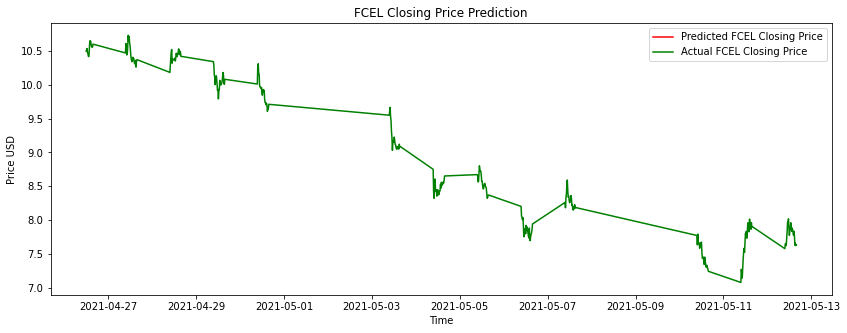

In [22]:
# Visualization
from sklearn.metrics import mean_squared_error
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(predicted_price['FCEL_predicted'], color = 'red', label= 'Predicted FCEL Closing Price')
plt.plot(test_data['FCEL'], color = 'green', label = 'Actual FCEL Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title('FCEL Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()